In [1]:
### Use gpd environment (a clean environment for geopandas)

In [2]:
# import geopandas as gpd
# from shapely.geometry import Point
import pandas as pd
import numpy as np
import pylab as pl
import os
from IPython import display
from subprocess import call
from datetime import datetime
import subprocess
import sys
#sys.path.append(r'C:\Users\Patrick\Documents\GitHub\PatchSim')
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim/')
import patchsim as sim
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


## Cleaning OD_Matrix_v3 and restricting to Nord-Kivu, Ituri

In [3]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_orig.csv')
# od_matrix = od_matrix[~od_matrix.Destination.str.startswith('POE_')] ## Dropping points of entry

# pop2018 = pd.read_csv('../data/pop_travel/DRC_Pop2018.csv')
# pop2018['ADM2_caps'] = pop2018.ADM2_NAME.str.upper()

# ## Matching names from shape file or OD_matrix
# match_dict = {'BAMBU':'BAMBU-MINES',
#              'MONGBALU':'MONGBWALU',
#              'NYAKUNDE':'NYANKUNDE',
#              'KATOYI':'KITOYI'}
# pop2018['ADM2_caps'] = pop2018.ADM2_caps.apply(lambda x: match_dict[x] if x in match_dict.keys() else x)

# ## Restricting analyses to Nord-Kivu and Ituri province health zones
# pop2018 = pop2018[(pop2018.ADM1_NAME.isin(['Nord-Kivu','Ituri']))]
# pop2018 = pop2018[['ADM2_caps','Pop2018']]
# od_matrix = od_matrix.merge(pop2018,left_on='Origin',right_on='ADM2_caps').merge(pop2018,left_on='Destination',right_on='ADM2_caps')
# od_matrix.drop(['ADM2_caps_x','ADM2_caps_y'],axis=1,inplace=True)
# od_matrix = od_matrix[['Origin','Pop2018_x','Destination','Pop2018_y','Travel_Time']]
# od_matrix.columns = ['Origin','Origin_Pop','Destination','Destination_Pop','Travel_Time']
# od_matrix.to_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv',index=None)

## Preparing PatchSim PatchFile and NetworkFile (Gravity) v3

In [4]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
# od_matrix['Grav'] = (od_matrix.Origin_Pop*od_matrix.Destination_Pop)/(od_matrix.Travel_Time**2)
# od_matrix = od_matrix.assign(norm_flow=od_matrix.Grav.div(od_matrix.groupby(['Origin']).Grav.transform('sum')))
# od_matrix = od_matrix[['Origin','Destination','norm_flow']]
# hz = od_matrix.Origin.unique()
# non_commute=0.85
# df = pd.DataFrame({'Origin':hz,'Destination':hz,'norm_flow':np.repeat(non_commute,len(hz))})
# od_matrix.norm_flow = od_matrix.norm_flow*(1-non_commute)
# od_matrix = od_matrix.append(df[['Origin','Destination','norm_flow']])
# od_matrix['temp'] = 0
# od_matrix.Origin = od_matrix.Origin.str.replace(' ','_')
# od_matrix.Destination = od_matrix.Destination.str.replace(' ','_')
# od_matrix[['Origin','Destination','temp','norm_flow']].to_csv('../data/patchsim/grav_drc_v3.csv',sep=' ',index=None,header=None)

# df = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
# df = df[['Origin','Origin_Pop']].drop_duplicates()
# df.Origin = df.Origin.str.replace(' ','_')
# df.to_csv('../data/patchsim/pop_drc_v3.csv',sep=' ',index=None,header=None)

## Running PatchSim on v3 files

In [5]:
stages = 6
sc = 'a' # sc='a' for baseline, sc='b' for pull-out

for s in range(stages):
    if s!=3:
        sim.run_disease_simulation(sim.read_config('../../data/patchsim/2019feb07/cfg_stage{}.txt'.format(s)),write_epi=True)
    else:
        sim.run_disease_simulation(sim.read_config('../../data/patchsim/2019feb07/cfg_stage{}{}.txt'.format(s,sc)),write_epi=True)

out_df = pd.DataFrame()
for s in range(stages):
    if s!=3:
        temp_df = pd.read_csv('../../outputs/2019feb07/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)
    else:
        temp_df = pd.read_csv('../../outputs/2019feb07/sample{}{}.out'.format(s,sc),delimiter=' ',header=None,index_col=0)
        
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)

## National ground truth vs simulated cases

(0, 210)

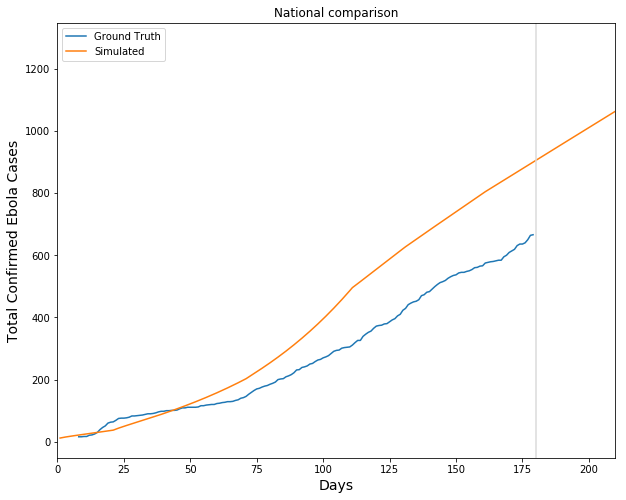

In [6]:
#New
fig= plt.figure(figsize=(10,8))
ax = plt.gca()
evd_df2 = pd.read_csv('../../data/Ebola_Updated_Jan23.csv', delimiter='\t')
evd_df2['Date'] = evd_df2.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt2 = evd_df2[evd_df2.health_zone=='all'].total_c.values
ax.plot(gt2,label='Ground Truth')
out_df.sum().cumsum().plot(label='Simulated',ax=ax)
ax.axvline(len(gt2),color='#dbdbdb')
plt.title('National comparison')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Total Confirmed Ebola Cases', fontsize=14)
plt.legend()
plt.xlim([0,len(gt2)+30])

# # Save the image in memory in PNG format
# png1 = io.BytesIO()
# fig.savefig(png1, format="png")

# # Load this image into PIL
# png2 = Image.open(png1)

# # Save as TIFF
# png2.save("../plots/plots_Jan_23/national_comparison_project.tiff")
# png1.close()





# Regional ground truth vs simulated cases 


#### Plot Without Projection 

(0, 180)

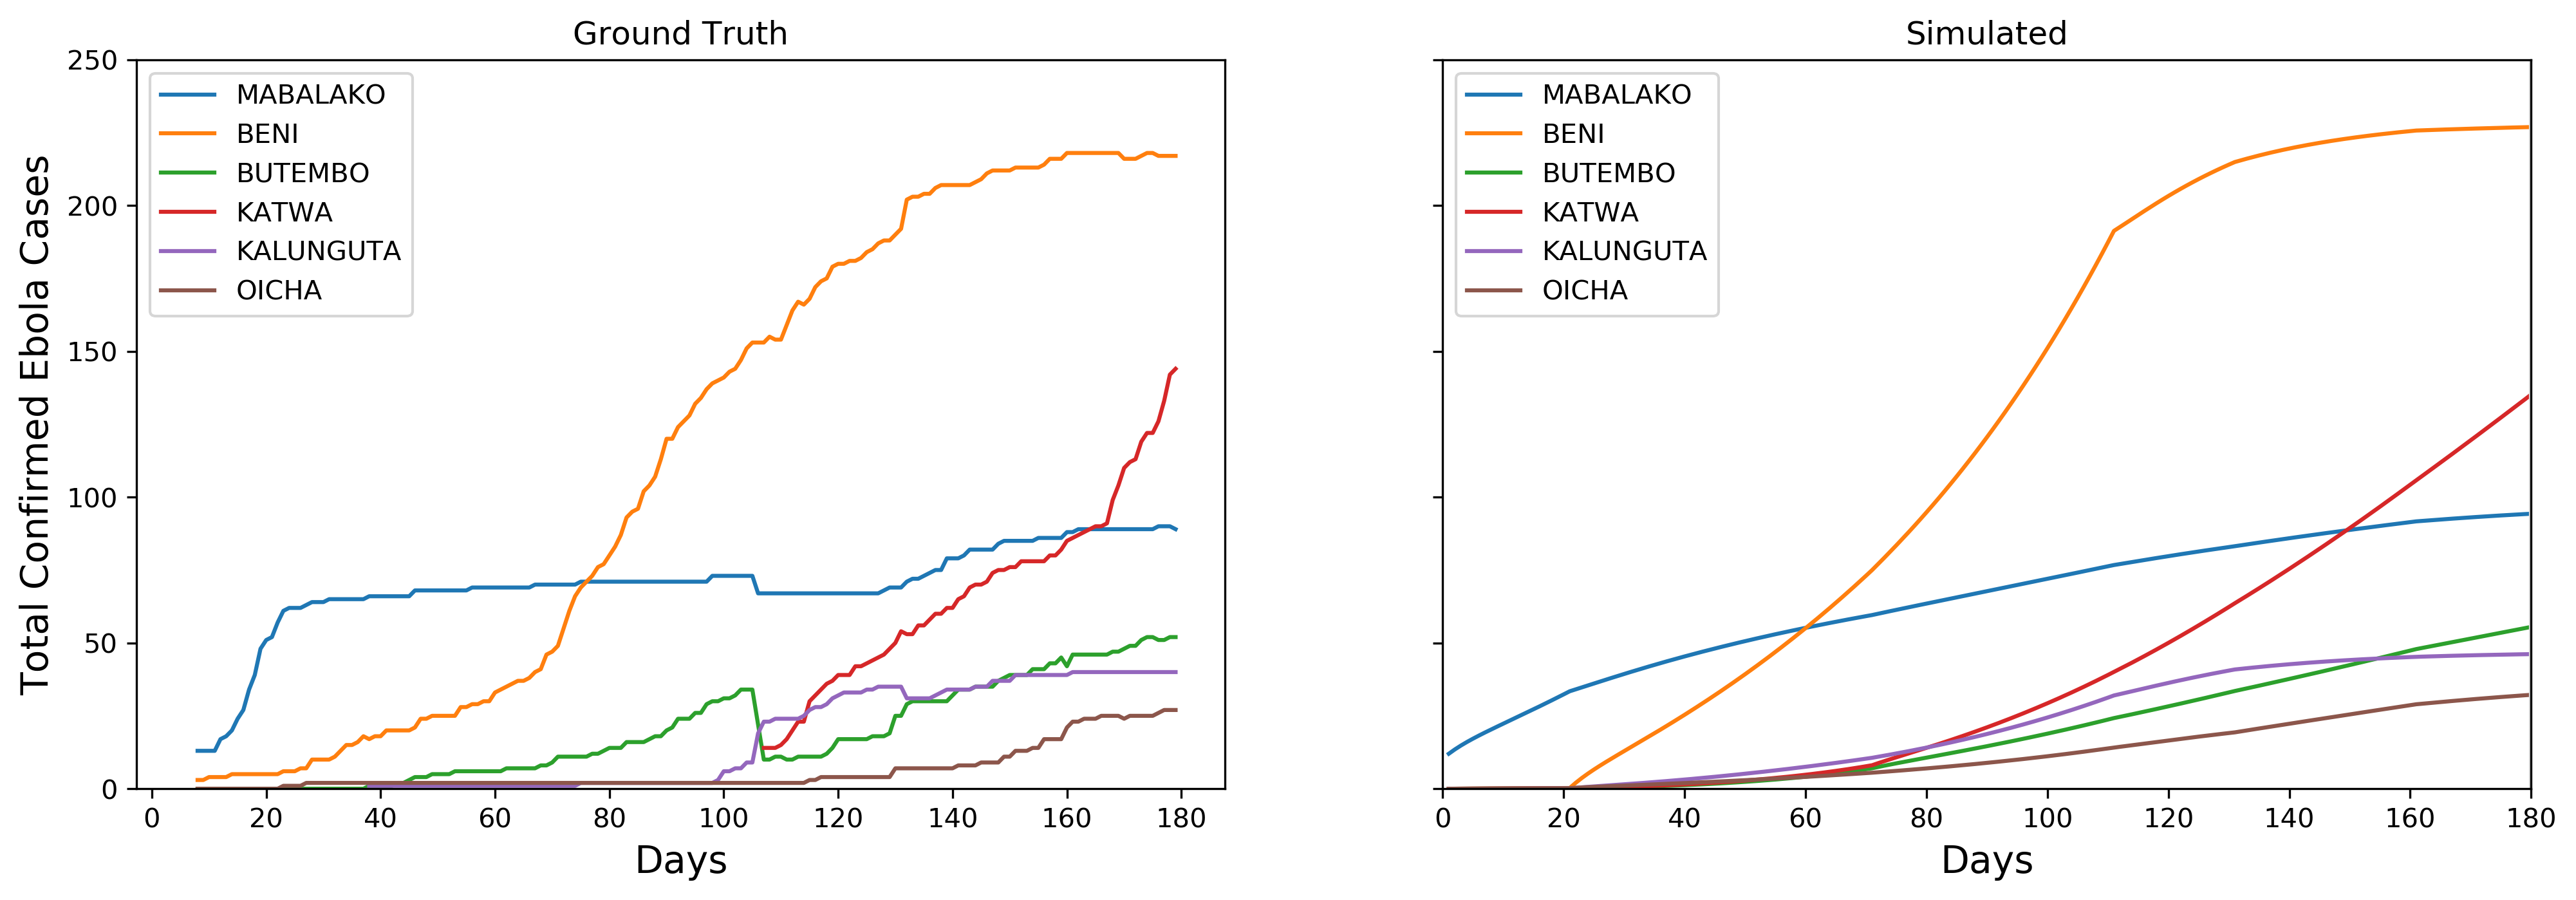

In [7]:
#Setting up Ground Truths Plot 
f,axarr = plt.subplots(1,2,figsize=(16,5),sharey=True, dpi=300)
key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA','KALUNGUTA','OICHA'] #Setting what health zones we are looking at 
for h in key_hzs:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[0],label=h)
axarr[0].set_title('Ground Truth')
axarr[0].set_xlabel('Days', fontsize=14)
axarr[0].set_ylabel('Total Confirmed Ebola Cases', fontsize=14)
axarr[0].set_ylim(0,250)

#Setting up the Simulated Plot 
out_df.loc[key_hzs].T.cumsum().plot(ax=axarr[1])
axarr[1].set_title('Simulated')
axarr[1].set_xlabel('Days', fontsize=14)

axarr[1].axvline(len(gt2),color='#dbdbdb') #AXV LINE: representing end of Grounded Truth Data 


#Setting the axis settings in intervals of 'n'
loc = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)

#Setting up x limit and title of saved graph 
l = axarr[1].legend()
l.set_title('')
plt.xlim([0,len(gt2)]) 

# # Save the image in memory in PNG format
# png1 = io.BytesIO()
# f.savefig(png1, format="png")

# # Load this image into PIL
# png2 = Image.open(png1)

# # Save as TIFF
# png2.save("../plots/plots_Jan_23/ground_truth_versus_simulation_epicurve.tiff")
# png1.close()


#### Plot With Projection 

(0, 210)

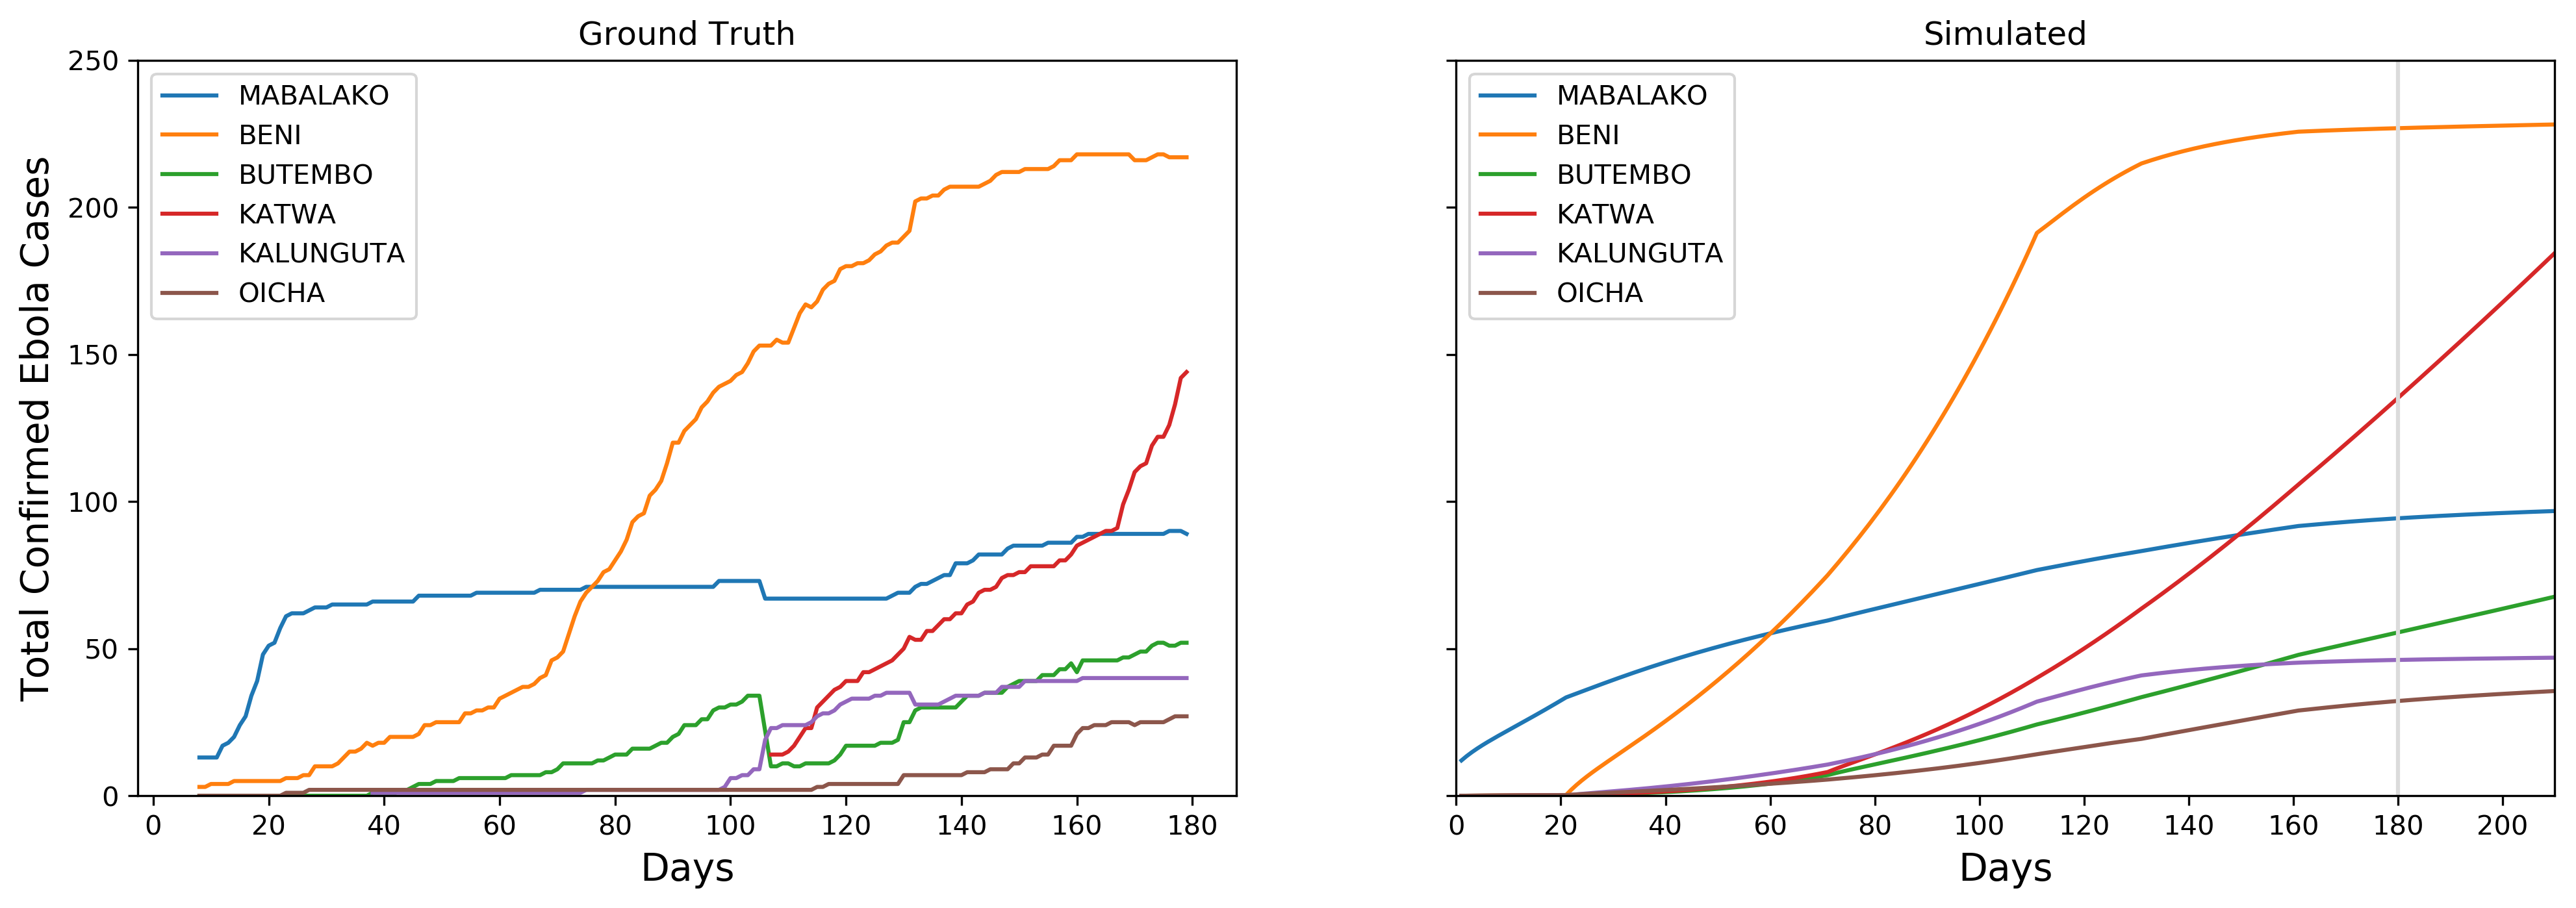

In [8]:
#Setting up Ground Truths Plot 
f,axarr = plt.subplots(1,2,figsize=(16,5),sharey=True, dpi=300)
key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA','KALUNGUTA','OICHA'] #Setting what health zones we are looking at 
for h in key_hzs:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[0],label=h)
axarr[0].set_title('Ground Truth')
axarr[0].set_xlabel('Days', fontsize=14)
axarr[0].set_ylabel('Total Confirmed Ebola Cases', fontsize=14)
axarr[0].set_ylim(0,250)

#Setting up the Simulated Plot 
out_df.loc[key_hzs].T.cumsum().plot(ax=axarr[1])
axarr[1].set_title('Simulated')
axarr[1].set_xlabel('Days', fontsize=14)

axarr[1].axvline(len(gt2-1),color='#dbdbdb') #AXV LINE: representing end of Grounded Truth Data 


#Setting the axis settings in intervals of 'n'
loc = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)

#Setting up x limit and title of saved graph 
l = axarr[1].legend()
l.set_title('')
plt.xlim([0,len(gt2)+30]) 

# # Save the image in memory in PNG format
# png1 = io.BytesIO()
# f.savefig(png1, format="png")

# # Load this image into PIL
# png2 = Image.open(png1)

# # Save as TIFF
# png2.save("../plots/plots_Jan_23/epicurve_ground&sim_projected.tiff")
# png1.close()



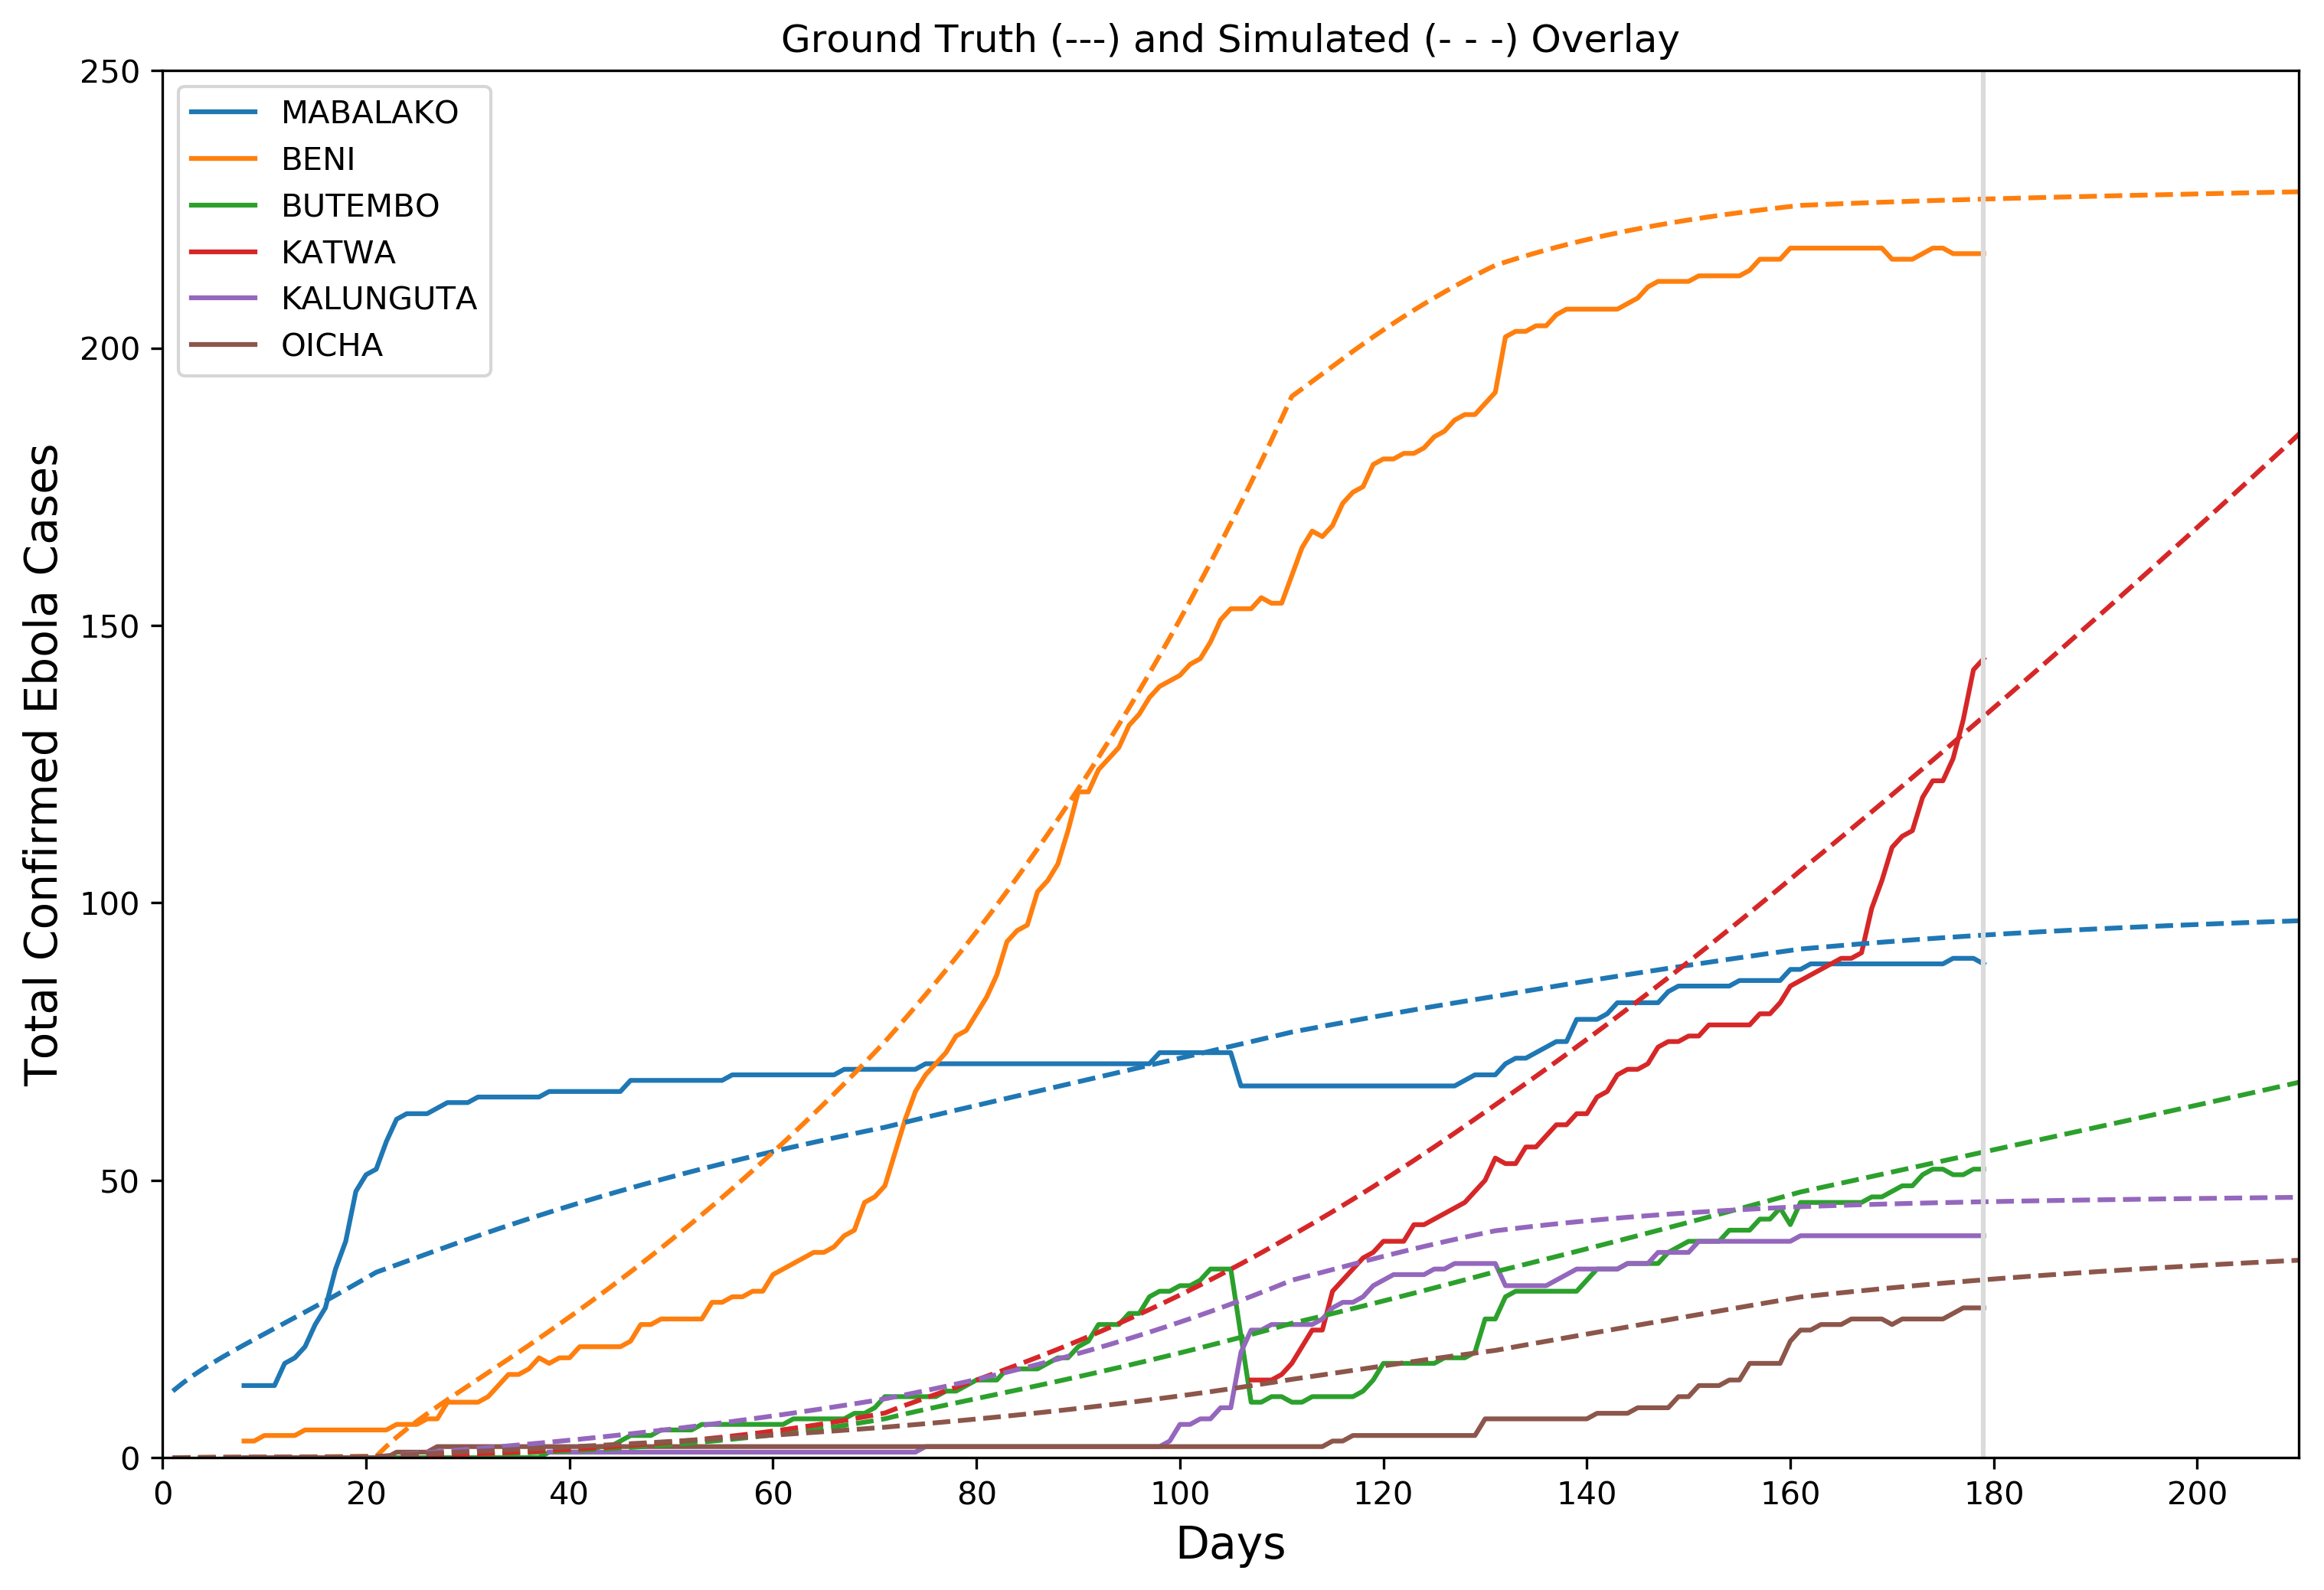

In [9]:
#Setting up Ground Truths Plot 
f,ax = plt.subplots(figsize=(12,8),sharey=True, dpi=300)
key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA','KALUNGUTA','OICHA'] #Setting what health zones we are looking at 
for h in key_hzs:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=ax,label=h)

#Setting up the Simulated Plot 
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
out_df.loc[key_hzs].T.cumsum().plot(ax=ax, style='--', color=cycle, legend=False)

ax.axvline(len(gt2)-1,color='#dbdbdb') #AXV LINE: representing end of Grounded Truth Data 

#Axes and Plot Titles
plt.title('Ground Truth (---) and Simulated (- - -) Overlay')
ax.set_xlabel('Days', fontsize=14)
plt.ylabel('Total Confirmed Ebola Cases', fontsize=14)
axarr[0].set_ylim(0,250)



#Setting the axis settings in intervals of 'n'
loc1 = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
loc2 = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)


#Setting up x limit and title of saved graph 
l = axarr[1].legend()
l.set_title('')
plt.xlim([0,len(gt2)+30]) 

#Plot Settings 
plt.ylim(0,250)       
plt.show()

# # Save the image in memory in PNG format
# png1 = io.BytesIO()
# f.savefig(png1, format="png")

# # Load this image into PIL
# png2 = Image.open(png1)

# # Save as TIFF
# png2.save("../plots/plots_Jan_23/epicurve_overlay_ground&sim_projected.tiff")
# png1.close()



## Plotting Ground Truth And Simulated Health In Pairs

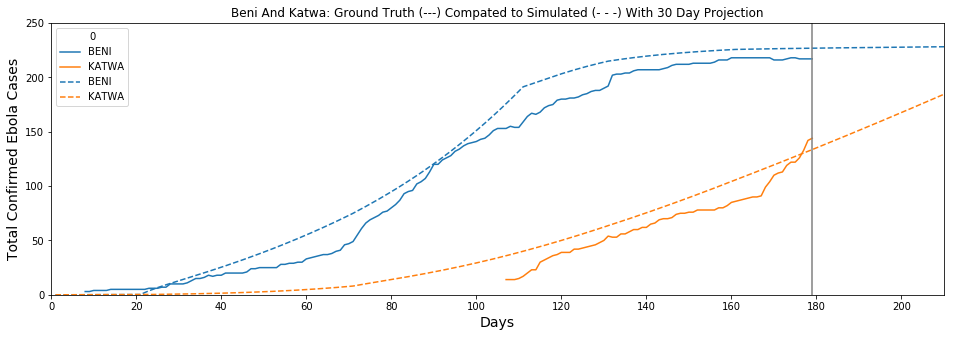

In [10]:
import matplotlib.ticker as plticker

#Setting up Ground Truths Plot 
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
f,ax = plt.subplots(figsize=(16,5),sharex=True)
key_hzs_2 = ['BENI','KATWA']
for h in key_hzs_2:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c', ax=ax, label=h, x_compat=True)

#Setting up the Simulated Plot 
out_df.loc[key_hzs_2].T.cumsum().plot(ax=ax, style='--', color=cycle)

## AXV LINES:
plt.axvline(len(gt2)-1, color='grey') #end of ground data 

#Axes and Plot Titles
plt.title('Beni And Katwa: Ground Truth (---) Compated to Simulated (- - -) With 30 Day Projection')
ax.set_xlabel('Days', fontsize=14)
plt.ylabel('Total Confirmed Ebola Cases', fontsize=14)
axarr[0].set_ylim(0,250)



#Plot Settings 
plt.xlim([0,len(gt2)+30])
loc = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.ylim(0,250)                              
plt.show()
                                    

### Mabalaki and Butembo
#### - - - is the simulated 

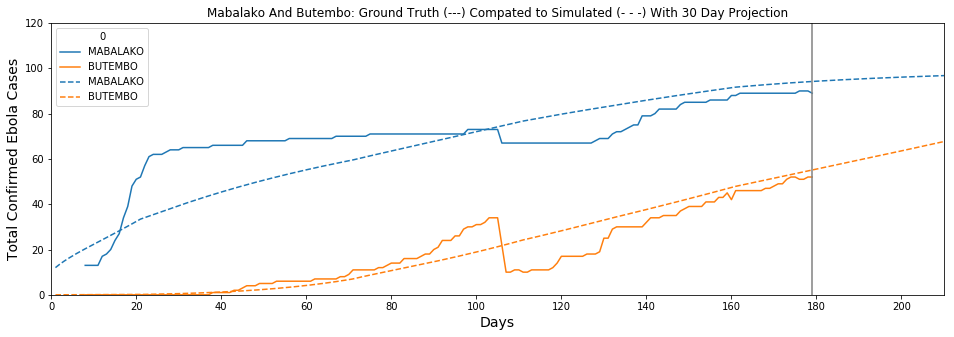

In [11]:
import matplotlib.ticker as plticker

#Setting up Ground Truths Plot 
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
f,ax = plt.subplots(figsize=(16,5),sharex=True)
key_hzs_2 = ['MABALAKO', 'BUTEMBO']
for h in key_hzs_2:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c', ax=ax, label=h, x_compat=True)

#Setting up the Simulated Plot 
out_df.loc[key_hzs_2].T.cumsum().plot(ax=ax, style='--', color=cycle)

## AXV LINES:
plt.axvline(len(gt2)-1, color='grey') #end of ground data 

#Axes and Plot Titles
plt.title('Mabalako And Butembo: Ground Truth (---) Compated to Simulated (- - -) With 30 Day Projection')
ax.set_xlabel('Days', fontsize=14)
plt.ylabel('Total Confirmed Ebola Cases', fontsize=14)
axarr[0].set_ylim(0,250)



#Plot Settings 
plt.xlim([0,len(gt2)+30])
loc = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.ylim(0,120)                                 
plt.show() 
                         

### KALUNGUTA and OICHA
#### - - - is the simulated 

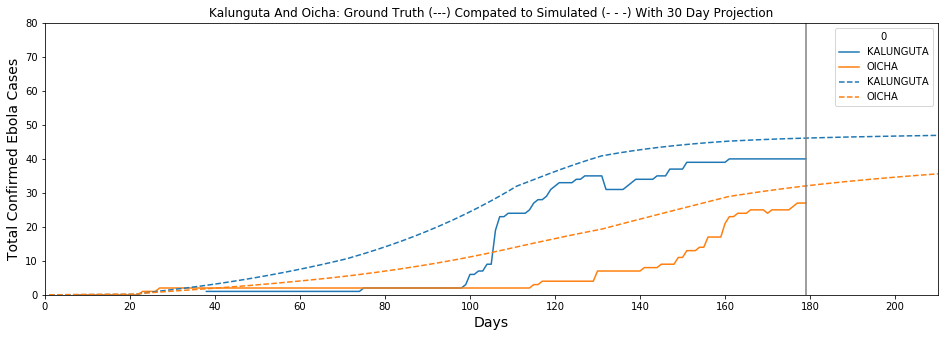

In [12]:
import matplotlib.ticker as plticker

#Setting up Ground Truths Plot 
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
f,ax = plt.subplots(figsize=(16,5),sharex=True)
key_hzs_2 = ['KALUNGUTA','OICHA']
for h in key_hzs_2:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c', ax=ax, label=h, x_compat=True)
#Setting up the Simulated Plot 
out_df.loc[key_hzs_2].T.cumsum().plot(ax=ax, style='--', color=cycle)

## AXV LINES:
plt.axvline(len(gt2)-1, color='grey') #end of ground data 

#Axes and Plot Titles
plt.title('Kalunguta And Oicha: Ground Truth (---) Compated to Simulated (- - -) With 30 Day Projection')
ax.set_xlabel('Days', fontsize=14)
plt.ylabel('Total Confirmed Ebola Cases', fontsize=14)
axarr[0].set_ylim(0,250)



#Plot Settings 
plt.xlim([0,len(gt2)+30])
loc = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.ylim(0,80)                                 
plt.show() 
                  

In [14]:
out_df.to_csv('../../outputs/forecast_2019jan23.csv')